# Fetal Cardiotocograph (CTG) Classification

#### Kate Stadelman

In [1]:
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from prettytable import PrettyTable
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, cross_val_predict, GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
import shap
%matplotlib inline

## Dataset


In [2]:
# Read in data, and display preview.
df = pd.read_csv('fetal_health.csv')
pd.set_option('display.max_columns', None)
df.sample(10)


,baseline_value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,mean_value_of_long_term_variability,histogram_width,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
2019,125,0.000,0.000,0.008,0.007,0.0,0.001,64,1.4,0,2.7,77,78,155,4,0,107,111,113,11,0,1
71,140,0.010,0.006,0.003,0.000,0.0,0.000,52,1.6,0,16.2,104,68,172,0,0,144,147,147,14,1,1
209,124,0.000,0.007,0.000,0.000,0.0,0.000,59,0.6,0,7.6,25,111,136,0,0,129,129,130,0,1,1
1624,126,0.012,0.002,0.007,0.001,0.0,0.000,53,2.6,0,0.2,86,84,170,5,0,135,134,140,12,0,1
775,137,0.000,0.003,0.001,0.000,0.0,0.000,77,0.2,40,6.6,29,127,156,2,0,138,141,141,3,0,2
1217,135,0.000,0.000,0.007,0.000,0.0,0.000,59,0.5,32,6.1,16,132,148,1,0,140,140,142,0,0,1
794,146,0.000,0.000,0.006,0.002,0.0,0.000,49,0.9,32,8.7,80,86,166,3,0,152,147,151,11,1,1
1438,146,0.006,0.000,0.005,0.000,0.0,0.000,37,0.9,0,7.9,49,126,175,2,0,155,152,154,4,0,1
1280,112,0.005,0.000,0.007,0.002,0.0,0.000,17,2.0,1,9.0,66,78,144,0,1,112,112,113,9,0,1
345,139,0.000,0.007,0.000,0.000,0.0,0.000,78,0.2,59,4.2,11,133,144,1,0,140,139,141,0,0,2


In [3]:
df.shape

(2126, 22)

In [4]:
# Descriptive Statistics.
df.describe()


,baseline_value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,mean_value_of_long_term_variability,histogram_width,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
count,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.00000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000
mean,133.303857,0.003178,0.009481,0.004366,0.001889,0.000003,0.000159,46.990122,1.332785,9.84666,8.187629,70.445908,93.579492,164.025400,4.068203,0.323612,137.452023,134.610536,138.090310,18.808090,0.320320,1.304327
std,9.840844,0.003866,0.046666,0.002946,0.002960,0.000057,0.000590,17.192814,0.883241,18.39688,5.628247,38.955693,29.560212,17.944183,2.949386,0.706059,16.381289,15.593596,14.466589,28.977636,0.610829,0.614377
min,106.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.000000,0.200000,0.00000,0.000000,3.000000,50.000000,122.000000,0.000000,0.000000,60.000000,73.000000,77.000000,0.000000,-1.000000,1.000000
25%,126.000000,0.000000,0.000000,0.002000,0.000000,0.000000,0.000000,32.000000,0.700000,0.00000,4.600000,37.000000,67.000000,152.000000,2.000000,0.000000,129.000000,125.000000,129.000000,2.000000,0.000000,1.000000
50%,133.000000,0.002000,0.000000,0.004000,0.000000,0.000000,0.000000,49.000000,1.200000,0.00000,7.400000,67.500000,93.000000,162.000000,3.000000,0.000000,139.000000,136.000000,139.000000,7.000000,0.000000,1.000000
75%,140.000000,0.006000,0.003000,0.007000,0.003000,0.000000,0.000000,61.000000,1.700000,11.00000,10.800000,100.000000,120.000000,174.000000,6.000000,0.000000,148.000000,145.000000,148.000000,24.000000,1.000000,1.000000
max,160.000000,0.019000,0.481000,0.015000,0.015000,0.001000,0.005000,87.000000,7.000000,91.00000,50.700000,180.000000,159.000000,238.000000,18.000000,10.000000,187.000000,182.000000,186.000000,269.000000,1.000000,3.000000


## Exploratory Data Analysis & Visualization

### Data Cleaning

#### Missing Data

In [5]:
# Check data types and null counts.
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2126 entries, 0 to 2125
Data columns (total 22 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   baseline_value                                          2126 non-null   int64  
 1   accelerations                                           2126 non-null   float64
 2   fetal_movement                                          2126 non-null   float64
 3   uterine_contractions                                    2126 non-null   float64
 4   light_decelerations                                     2126 non-null   float64
 5   severe_decelerations                                    2126 non-null   float64
 6   prolongued_decelerations                                2126 non-null   float64
 7   abnormal_short_term_variability                         2126 non-null   int64  
 8   mean_value_of_short_term_variability  

#### Target Balance/Imbalance

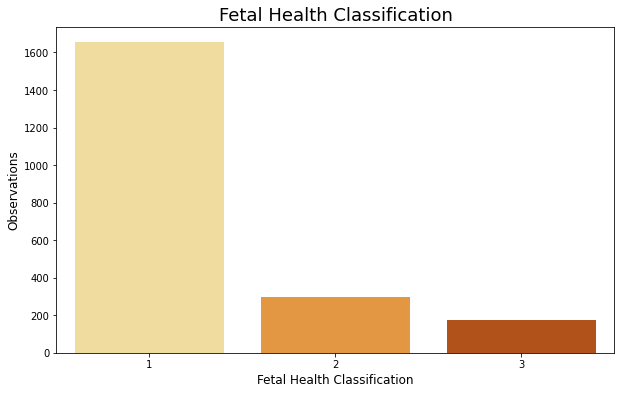

In [6]:
# Check balance of target variable.
plt.figure(figsize=(10,6))
sns.countplot(data=df, x='fetal_health', palette='YlOrBr')
plt.title('Fetal Health Classification', fontsize=18)
plt.xlabel('Fetal Health Classification', fontsize=12)
plt.ylabel('Observations', fontsize=12)
plt.show()


In [7]:
# Given the imbalanced nature of the data, as well as the extremely small number of class 3 observations,
# we create a new target variable of 0 = Normal and 1 = Suspect/Pathological.

df['target'] = df.fetal_health.apply(lambda x: 0 if x == 1 else 1)
df.drop(columns=['fetal_health'], inplace=True)


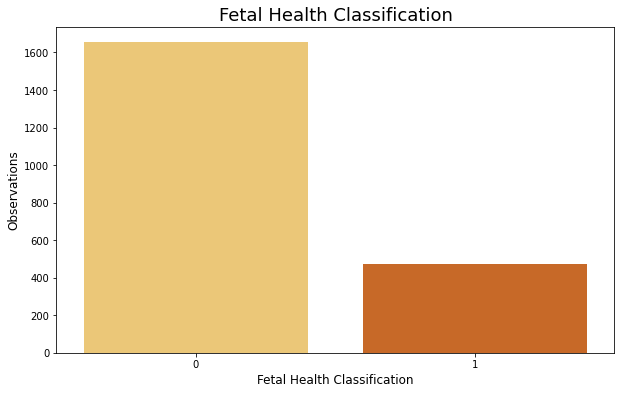

In [8]:
# Check balance of mapped target variable.
plt.figure(figsize=(10,6))
sns.countplot(data=df, x='target', palette='YlOrBr')
plt.title('Fetal Health Classification', fontsize=18)
plt.xlabel('Fetal Health Classification', fontsize=12)
plt.ylabel('Observations', fontsize=12)
plt.show()


#### Outliers

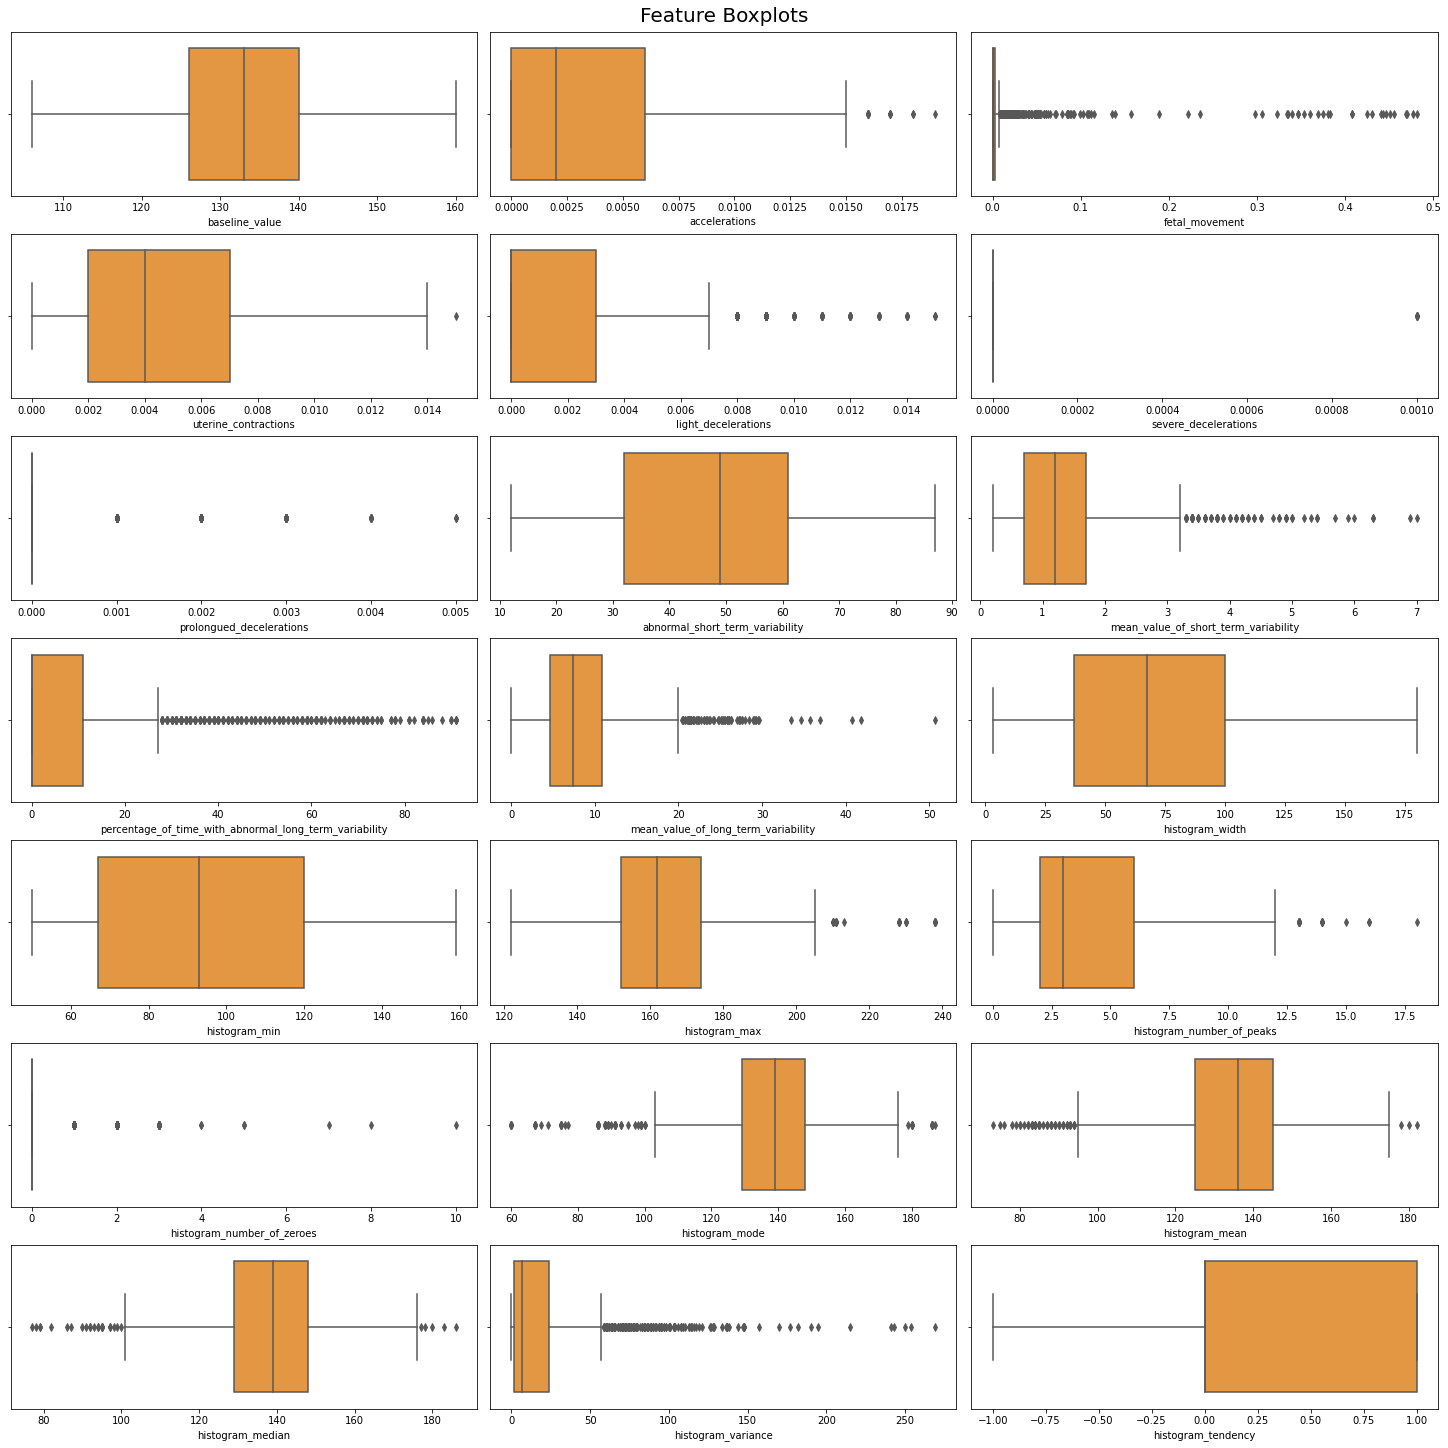

In [9]:
# Feature boxplots.
features = df.columns[:-1]
l,w = 7,3
plots = [ [i,j] for i in range(l) for j in range(w) ]
fig, axs = plt.subplots(nrows=l, ncols=w, constrained_layout=True, figsize=(20,20))
fig.suptitle('Feature Boxplots', fontsize=20)
for i in range(len(features)):
    j,k = plots[i]
    sns.boxplot(x=features[i], data=df, ax=axs[j,k], palette='YlOrBr')
plt.show()


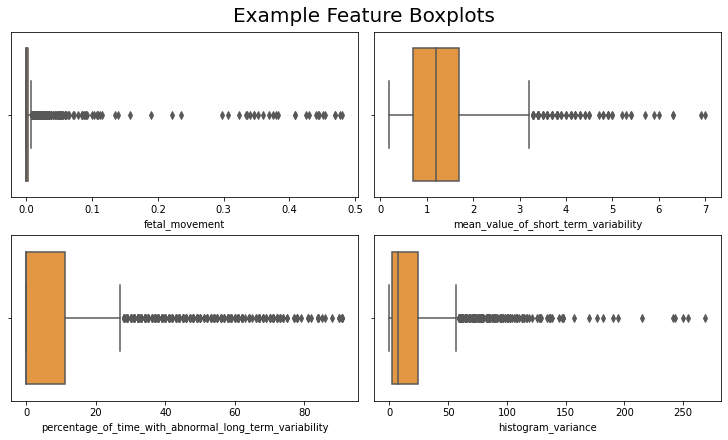

In [10]:
# Feature boxplots.
outliers = ['fetal_movement','mean_value_of_short_term_variability','percentage_of_time_with_abnormal_long_term_variability','histogram_variance']
l,w = 2,2
plots = [ [i,j] for i in range(l) for j in range(w) ]
fig, axs = plt.subplots(nrows=l, ncols=w, constrained_layout=True, figsize=(10,6))
fig.suptitle('Example Feature Boxplots', fontsize=20)
for i in range(len(outliers)):
    j,k = plots[i]
    sns.boxplot(x=outliers[i], data=df[outliers], ax=axs[j,k], palette='YlOrBr')
plt.show()


In [11]:
# For each variable, remove values below Q1 - 1.5*IQR and values above Q3 + 1.5*IQR as outliers.
def tag_non_outliers(df, col):
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    cutoff_below = q1 - (1.5 * iqr)
    cutoff_above = q3 + (1.5 * iqr)
    return df[col].apply(lambda x: x <= cutoff_above and x >= cutoff_below)

# Certain features contain a disproportionate number of outliers. If we include these features and remove
# outliers, it cuts the dataset in half. We drop these features.
include_cols = set(df.columns[:-1])
include_cols.remove('fetal_movement')
include_cols.remove('histogram_number_of_zeroes')

df_not_outliers = pd.DataFrame()
for column in include_cols:
    df_not_outliers[column] = tag_non_outliers(df, column)
df_not_outliers['true_cnt'] = df_not_outliers.sum(axis=1)

clean_df = df[df_not_outliers.true_cnt == len(include_cols)].copy()
clean_df.drop(columns=list(set(df.columns[:-1]).difference(include_cols)), inplace=True)

print('Observations prior to removal of outliers:', df.shape[0])
print('Observations after removal of outliers:', clean_df.shape[0])


Observations prior to removal of outliers: 2126
Observations after removal of outliers: 1349


#### Data Distributions

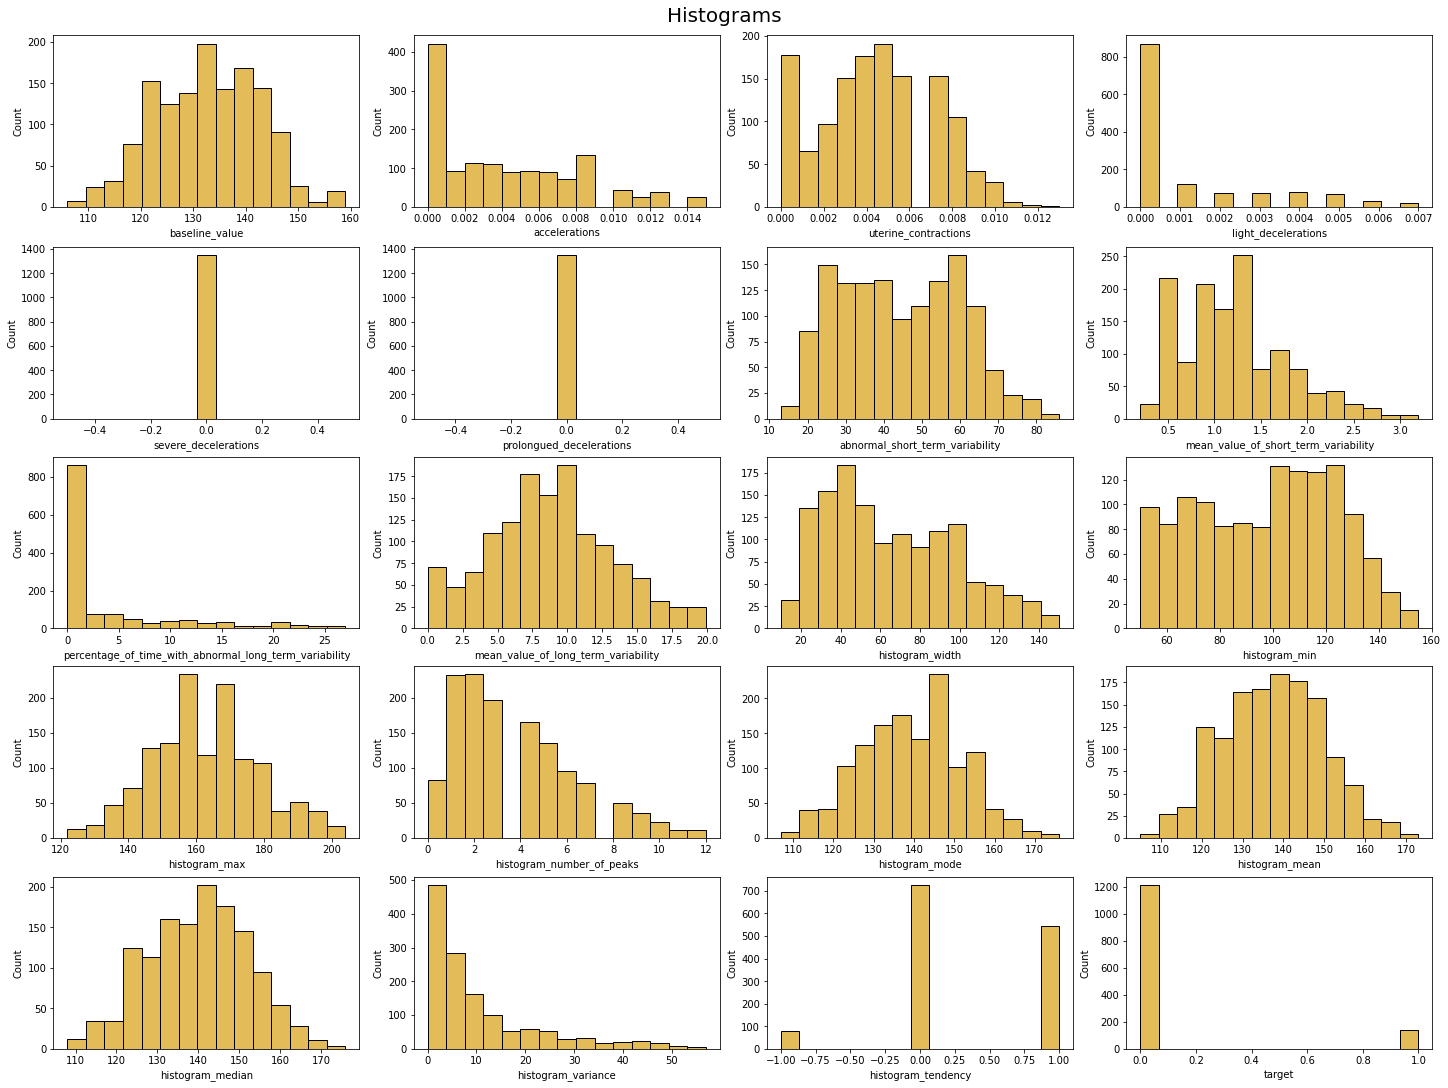

In [12]:
# Histograms.
l,w = 5,4
plots = [ [i,j] for i in range(l) for j in range(w) ]
fig, axs = plt.subplots(nrows=l, ncols=w, constrained_layout=True, figsize=(20,15))
fig.suptitle('Histograms', fontsize=20)
for i in range(len(clean_df.columns)):
    j,k = plots[i]
    sns.histplot(x=clean_df.columns[i], data=clean_df, bins=15, ax=axs[j,k], color='goldenrod')
plt.show()


In [13]:
# After removal of outliers, two columns have only a single value. These are removed.
clean_df.drop(columns=['severe_decelerations','prolongued_decelerations'], inplace=True)


### Data Transformation

In [14]:
# Scale data with MinMaxScaler to retain variance.
minmax = MinMaxScaler()
scaled_df = clean_df.copy()
scaled_df[clean_df.columns[:-1]] = minmax.fit_transform(scaled_df[clean_df.columns[:-1]])
scaled_df.head(10)


,baseline_value,accelerations,uterine_contractions,light_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,mean_value_of_long_term_variability,histogram_width,histogram_min,histogram_max,histogram_number_of_peaks,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,target
1,0.490566,0.400000,0.461538,0.428571,0.054795,0.633333,0.000000,0.522613,0.857143,0.171429,0.926829,0.500000,0.492754,0.455882,0.470588,0.210526,0.5,0
2,0.509434,0.200000,0.615385,0.428571,0.041096,0.633333,0.000000,0.673367,0.857143,0.171429,0.926829,0.416667,0.492754,0.441176,0.441176,0.228070,0.5,0
4,0.490566,0.466667,0.615385,0.000000,0.041096,0.733333,0.000000,1.000000,0.764286,0.028571,0.585366,0.750000,0.434783,0.455882,0.441176,0.192982,1.0,0
7,0.301887,0.000000,0.000000,0.000000,0.958904,0.100000,0.222222,0.783920,0.414286,0.114286,0.097561,0.000000,0.217391,0.250000,0.220588,0.052632,1.0,1
8,0.301887,0.000000,0.153846,0.000000,0.972603,0.100000,0.185185,0.683417,0.414286,0.114286,0.097561,0.000000,0.217391,0.250000,0.220588,0.052632,1.0,1
9,0.301887,0.000000,0.230769,0.000000,1.000000,0.033333,0.222222,0.532663,0.414286,0.114286,0.097561,0.083333,0.217391,0.250000,0.220588,0.017544,1.0,1
12,0.471698,0.333333,0.615385,0.428571,0.205479,0.400000,0.000000,0.648241,0.400000,0.361905,0.390244,0.416667,0.405797,0.426471,0.426471,0.122807,1.0,0
13,0.471698,0.600000,0.461538,0.285714,0.205479,0.433333,0.000000,0.271357,0.550000,0.200000,0.439024,0.166667,0.492754,0.470588,0.485294,0.175439,1.0,0
23,0.415094,0.000000,0.000000,0.000000,0.917808,0.100000,0.000000,0.341709,0.042857,0.609524,0.097561,0.000000,0.275362,0.279412,0.250000,0.017544,1.0,1
26,0.339623,0.000000,0.000000,0.000000,1.000000,0.066667,0.518519,0.241206,0.100000,0.685714,0.292683,0.083333,0.275362,0.308824,0.279412,0.000000,0.0,1


### Feature Extraction

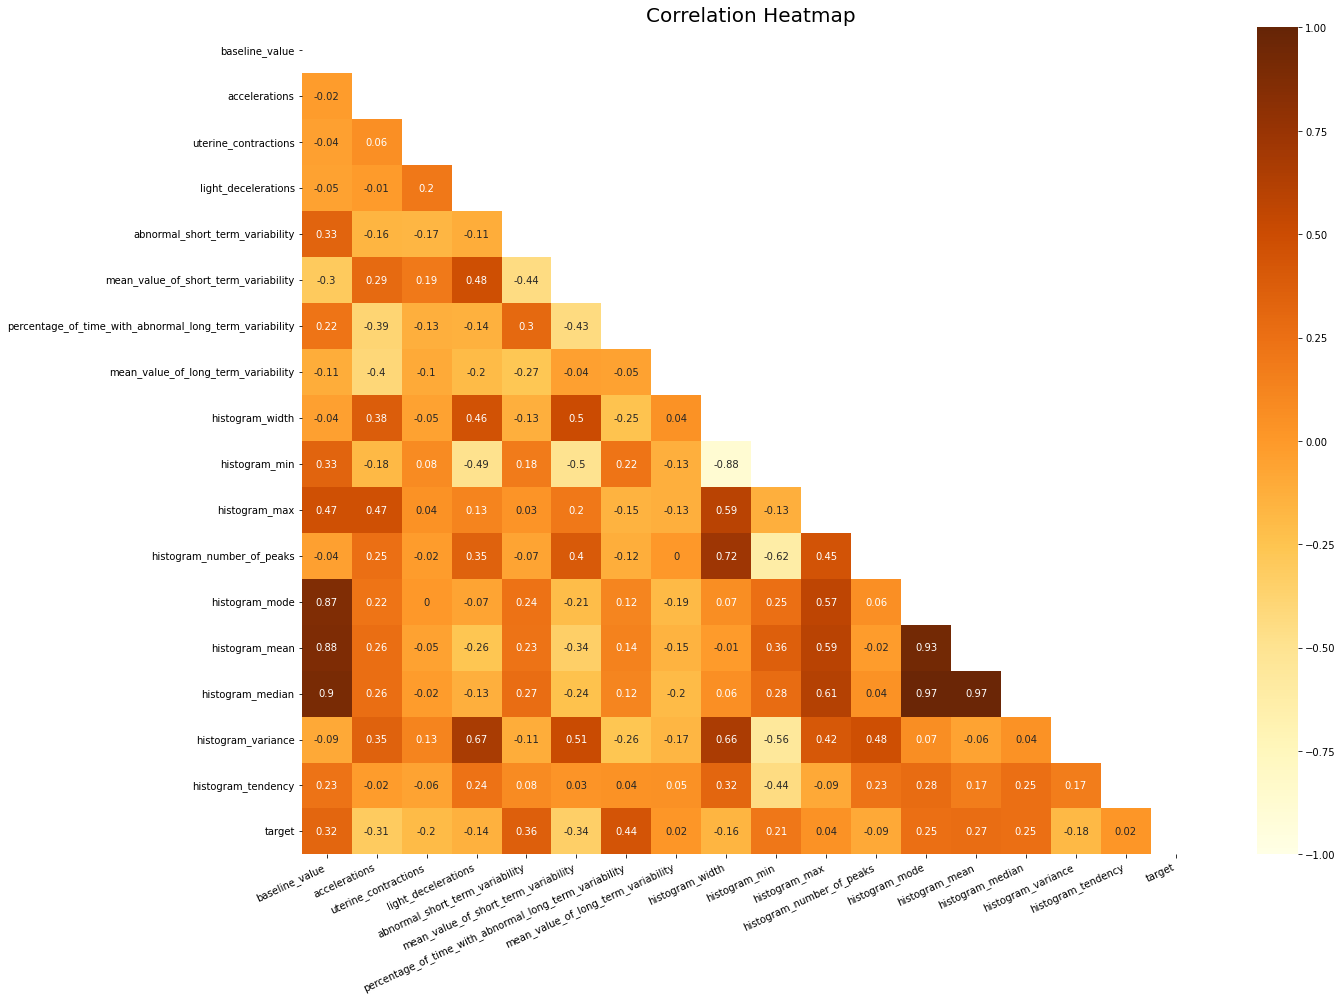

In [15]:
# Several features appear to be highly correlated to each other.
corr_matrix = clean_df.corr()
fig, ax = plt.subplots(figsize=(20,14))
mask = np.zeros_like(corr_matrix, dtype=bool)   # returns an array of False values with same shape as corr dataframe
mask[np.triu_indices_from(mask)] = True  # creates a boolean mask by making half the zero values == True
ax = sns.heatmap(corr_matrix.round(2), mask=mask, ax=ax, annot=True, vmin=-1, vmax=1, annot_kws={'fontsize':10}, cmap='YlOrBr')
ax.set_xticklabels(ax.xaxis.get_ticklabels())
ax.set_yticklabels(ax.yaxis.get_ticklabels())
plt.title('Correlation Heatmap', fontsize=20)
plt.xticks(rotation=25, ha='right')
plt.tight_layout()
plt.show()


In [16]:
# Define arrays for remainder of analysis.
X = clean_df.drop('target', axis=1)
y = clean_df['target'].copy()


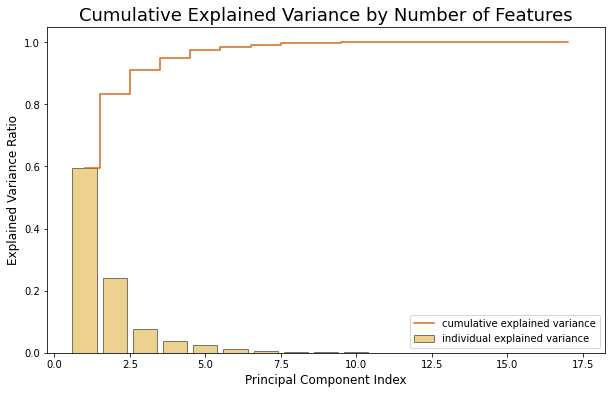

In [17]:
# Compute covariance matrix, and visualize cumulative sum of explained variances to choose right number of PCA dimensions.
cov_mat = np.cov(X.T)
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)

# Calculate cumulative sum of explained variances.
tot = sum(eigen_vals)
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

# Plot explained variances
plt.figure(figsize=(10,6))
plt.bar(range(1,18), var_exp, alpha=0.5, align='center', label='individual explained variance', color='goldenrod', edgecolor = 'black')
plt.step(range(1,18), cum_var_exp, where='mid', label='cumulative explained variance', color='chocolate')
plt.title('Cumulative Explained Variance by Number of Features', fontsize=18)
plt.ylabel('Explained Variance Ratio', fontsize=12)
plt.xlabel('Principal Component Index', fontsize=12)
plt.legend(loc='best')
plt.show()


In [18]:
# 99% of the variance is explained with seven components.
print(f'Cumulative explained variance from PCA components: {cum_var_exp[6]:.3f}.')
pca = PCA(n_components=7)
X_pca = pca.fit_transform(X)


Cumulative explained variance from PCA components: 0.992.


In [19]:
# Let's try to understand how principal components are related to our features.
pca_features = pd.DataFrame(pca.components_,columns=clean_df.columns[:-1], 
                            index=[1,2,3,4,5,6,7]).reset_index()
pca_features.rename(columns={'index':'PC'}, inplace=True)
pca_features


,PC,baseline_value,accelerations,uterine_contractions,light_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,mean_value_of_long_term_variability,histogram_width,histogram_min,histogram_max,histogram_number_of_peaks,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency
0,1,-0.034825,0.000031,-2.741036e-06,0.000022,-0.067018,0.007306,-0.041675,0.006414,0.761092,-0.584469,0.176623,0.044225,-0.011799,-0.037211,-0.016135,0.191419,0.004795
1,2,0.319220,0.000041,-9.633906e-07,-0.000007,0.186990,-0.004432,0.025467,-0.035264,0.168193,0.278767,0.446960,0.010603,0.434026,0.422785,0.431663,0.043278,0.002084
2,3,0.056474,-0.000064,-3.821224e-05,0.000001,0.932674,-0.012459,0.141991,-0.053327,-0.009598,-0.215900,-0.225498,0.002804,-0.014917,-0.051627,-0.010949,-0.055761,0.009518
3,4,-0.266322,0.000072,3.542958e-05,0.000020,0.258316,0.009174,-0.124557,-0.098960,0.095694,0.430354,0.526048,0.017238,-0.310464,-0.247168,-0.258979,0.373868,-0.035229
4,5,0.034921,0.000036,5.475919e-05,0.000099,-0.039318,0.010474,-0.074471,-0.134430,-0.215663,-0.092374,-0.308037,-0.015629,0.226228,0.002155,0.130993,0.868728,0.017366
5,6,0.060244,-0.000171,-1.494725e-05,0.000032,-0.118732,-0.010977,0.970082,-0.010176,0.024763,0.050275,0.075039,0.034658,-0.055952,-0.057781,-0.072961,0.138494,-0.006662
6,7,-0.536323,0.000463,2.472953e-05,-0.000050,-0.037780,0.004490,0.073028,-0.785113,0.012387,-0.035275,-0.022888,0.024814,0.175066,0.092733,0.135821,-0.170114,0.001697


In [20]:
# Find lables for principal components
principal_components = [pca_features.columns[1:][np.argmax(abs(pca_features[pca_features.columns[1:]][ pca_features['PC'] == i + 1 ]))] for i in range(7)]
principal_components[1] = 'histogram_mode'      ## Very close tie between histogram_max / histogram_mode, so leaving PC-4 as histogram_max
principal_components


['histogram_width',
 'histogram_mode',
 'abnormal_short_term_variability',
 'histogram_max',
 'histogram_variance',
 'percentage_of_time_with_abnormal_long_term_variability',
 'mean_value_of_long_term_variability']

## Data Splitting

In [21]:
# Split data into training and test sets.
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=36)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


(944, 7) (944,)
(405, 7) (405,)


## Model Building

In [22]:
# Random Forest
rf_clf = RandomForestClassifier(random_state=36)
rf_clf.fit(X_train, y_train)


RandomForestClassifier(random_state=36)

In [23]:
# Logistic Regression
log_reg = LogisticRegression(solver='lbfgs', max_iter=1000, random_state=36)
log_reg.fit(X_train, y_train)


LogisticRegression(max_iter=1000, random_state=36)

In [24]:
# K-Nearest Neighbors
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_train)


KNeighborsClassifier()

In [25]:
models = [ rf_clf, log_reg, knn_clf ]

table_train = PrettyTable()
table_test = PrettyTable()
fields = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']
table_train.field_names = fields
table_test.field_names = fields

for model in models:
    # Training metrics.
    y_pred_train = model.predict(X_train)
    accuracy_train = accuracy_score(y_train, y_pred_train)
    precision_train = precision_score(y_train, y_pred_train)
    recall_train = recall_score(y_train, y_pred_train)
    f1_train = f1_score(y_train, y_pred_train)
    roc_train = roc_auc_score(y_train, y_pred_train)
    table_train.add_row([type(model).__name__, format(accuracy_train, '.3f'), format(precision_train, '.3f'), format(recall_train,'.3f'), 
                         format(f1_train,'.3f'), format(roc_train,'.3f')])
    
    # Test metrics.
    y_pred_test = model.predict(X_test)
    accuracy_test = accuracy_score(y_test, y_pred_test)
    precision_test = precision_score(y_test, y_pred_test)
    recall_test = recall_score(y_test, y_pred_test)
    f1_test = f1_score(y_test, y_pred_test)
    roc_test = roc_auc_score(y_test, y_pred_test)
    table_test.add_row([type(model).__name__, format(accuracy_test, '.3f'), format(precision_test, '.3f'), format(recall_test,'.3f'), 
                         format(f1_test,'.3f'), format(roc_test,'.3f')])
    

print('BASELINE SCORES FOR TRAINING DATA')
print(table_train)
print('\n\nBASELINE SCORES FOR TEST DATA')
print(table_test)

BASELINE SCORES FOR TRAINING DATA
+------------------------+----------+-----------+--------+----------+---------+
|         Model          | Accuracy | Precision | Recall | F1 Score | ROC AUC |
+------------------------+----------+-----------+--------+----------+---------+
| RandomForestClassifier |  1.000   |   1.000   | 1.000  |  1.000   |  1.000  |
|   LogisticRegression   |  0.912   |   0.647   | 0.427  |  0.515   |  0.699  |
|  KNeighborsClassifier  |  0.932   |   0.767   | 0.544  |  0.636   |  0.762  |
+------------------------+----------+-----------+--------+----------+---------+


BASELINE SCORES FOR TEST DATA
+------------------------+----------+-----------+--------+----------+---------+
|         Model          | Accuracy | Precision | Recall | F1 Score | ROC AUC |
+------------------------+----------+-----------+--------+----------+---------+
| RandomForestClassifier |  0.948   |   0.759   | 0.611  |  0.677   |  0.796  |
|   LogisticRegression   |  0.928   |   0.630   | 0.47

In [26]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16)
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)
    plt.grid(True)

In [27]:
# Logistic Regression ROC Curve Data
preds_lr = cross_val_predict(log_reg, X_train, y_train, cv=3, method='predict_proba')
scores_lr = preds_lr[:,1]
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_train, scores_lr)

# KNN ROC Curve Data
preds_knn = cross_val_predict(knn_clf, X_train, y_train, cv=3, method='predict_proba')
scores_knn = preds_knn[:,1]
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_train, scores_knn)

# Random Forest ROC Curve Data
preds_rf = cross_val_predict(rf_clf, X_train, y_train, cv=3, method='predict_proba')
scores_rf = preds_rf[:,1]
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_train, scores_rf)


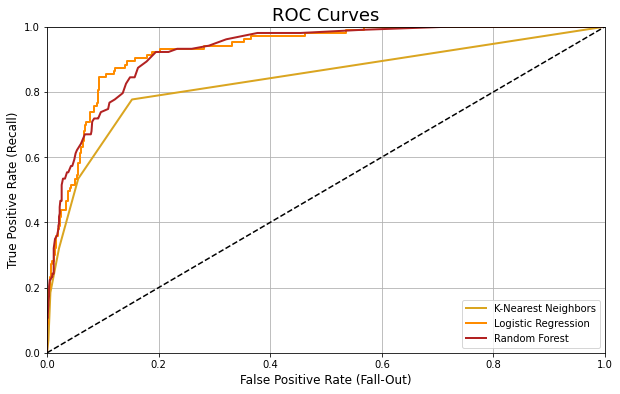

In [28]:
# ROC Curves
plt.figure(figsize=(10, 6))
plt.plot(fpr_knn, tpr_knn, linewidth=2, label='K-Nearest Neighbors', color='goldenrod')
plt.plot(fpr_lr, tpr_lr, linewidth=2, label='Logistic Regression', color='darkorange')
plt.plot(fpr_rf, tpr_rf, linewidth=2, label='Random Forest', color='firebrick')
plt.plot([0, 1], [0, 1], 'k--')
plt.axis([0, 1, 0, 1])
plt.title('ROC Curves', fontsize=18)
plt.xlabel('False Positive Rate (Fall-Out)', fontsize=12)
plt.ylabel('True Positive Rate (Recall)', fontsize=12)
plt.grid(True)   
plt.legend(loc='lower right')
plt.show()


## Model Optimization & Model Selection

### Hyperparameter Tuning


#### Random Forest

In [29]:
# Random Forest
rf = RandomForestClassifier(random_state=36)
rf_pg = {
    'n_estimators': [50, 70, 100],
    'max_depth': [2, 3, 5],
    'oob_score': [True, False],
    'class_weight': [{0:.09, 1:.91}, {0:.1, 1:.9}]
}
rf_grid = GridSearchCV(rf, param_grid=rf_pg, cv=10, scoring='recall')
with joblib.parallel_backend('threading', n_jobs=4):
    rf_grid.fit(X_train, y_train)

# Print best parameters.
rf_grid.best_params_


{'class_weight': {0: 0.09, 1: 0.91},
 'max_depth': 2,
 'n_estimators': 100,
 'oob_score': True}

In [30]:
# Use best model to find new metrics.
rf_final = rf_grid.best_estimator_
rf_final.fit(X_train, y_train)
print('Random Forest Classification Report:')
print(classification_report(y_train, rf_final.predict(X_train)))
print(f'ROC AUC: {roc_auc_score(y_train, rf_final.predict(X_train)):.3f}')


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.85      0.91       841
           1       0.43      0.91      0.58       103

    accuracy                           0.86       944
   macro avg       0.71      0.88      0.75       944
weighted avg       0.93      0.86      0.88       944

ROC AUC: 0.881


#### Logistic Regression 

In [31]:
# Logistic Regression GridSearchCV
lr = LogisticRegression(max_iter=5000, random_state=36)
lr_pg = {
    'penalty': ['l1','l2'], 
    'solver': ['liblinear','saga'], 
    'class_weight': [{0:.01, 1:.99}, {0:.1, 1:.9}, {0:.15, 1:.85}], 
    'C': [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 1] 
}
lr_grid = GridSearchCV(lr, param_grid=lr_pg, cv=10, scoring='roc_auc')
lr_grid.fit(X_train, y_train)

# Print best parameters.
lr_grid.best_params_

{'C': 1,
 'class_weight': {0: 0.15, 1: 0.85},
 'penalty': 'l2',
 'solver': 'liblinear'}

In [32]:
# Use best model to find new metrics.
lr_final = lr_grid.best_estimator_
lr_final.fit(X_train, y_train)
print('Logistic Regression Classification Report:')
print(classification_report(y_train, lr_final.predict(X_train)))
print(f'ROC AUC: {roc_auc_score(y_train, lr_final.predict(X_train)):.3f}')

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.89      0.93       841
           1       0.48      0.87      0.62       103

    accuracy                           0.88       944
   macro avg       0.73      0.88      0.78       944
weighted avg       0.93      0.88      0.90       944

ROC AUC: 0.880


#### K-Nearest Neighbors

In [33]:
# KNN
knn = KNeighborsClassifier()
knn_pg = {
    'n_neighbors': [ i for i in range(5,15) ], 
    'leaf_size': [10,30,50], 
    'algorithm': ['ball_tree','kd_tree'], 
    'p': [1,2],
    'metric':['minkowski','chebyshev'] 
}
knn_grid = GridSearchCV(knn, param_grid=knn_pg, cv=10, scoring='recall')
with joblib.parallel_backend('threading', n_jobs=4):
    knn_grid.fit(X_train, y_train)

# Print best parameters.
knn_grid.best_params_


{'algorithm': 'ball_tree',
 'leaf_size': 10,
 'metric': 'minkowski',
 'n_neighbors': 5,
 'p': 1}

In [34]:
# Use best model to find new metrics.
knn_final = knn_grid.best_estimator_
knn_final.fit(X_train, y_train)
print('K-Nearest Neighbors Classification Report:')
print(classification_report(y_train, knn_final.predict(X_train)))
print(f'ROC AUC: {roc_auc_score(y_train, knn_final.predict(X_train)):.3f}')


K-Nearest Neighbors Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       841
           1       0.74      0.59      0.66       103

    accuracy                           0.93       944
   macro avg       0.85      0.78      0.81       944
weighted avg       0.93      0.93      0.93       944

ROC AUC: 0.784


Random Forest slightly edges out Logistic Regression for the best Recall for Class 1.

### ROC Curves

In [35]:
# Logistic Regression ROC Curve Data
preds_lr = cross_val_predict(lr_final, X_train, y_train, cv=3, method='predict_proba')
scores_lr = preds_lr[:,1]
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_train, scores_lr)

# KNN ROC Curve Data
preds_knn = cross_val_predict(knn_final, X_train, y_train, cv=3, method='predict_proba')
scores_knn = preds_knn[:,1]
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_train, scores_knn)

# Random Forest ROC Curve Data
preds_rf = cross_val_predict(rf_final, X_train, y_train, cv=3, method='predict_proba')
scores_rf = preds_rf[:,1]
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_train, scores_rf)

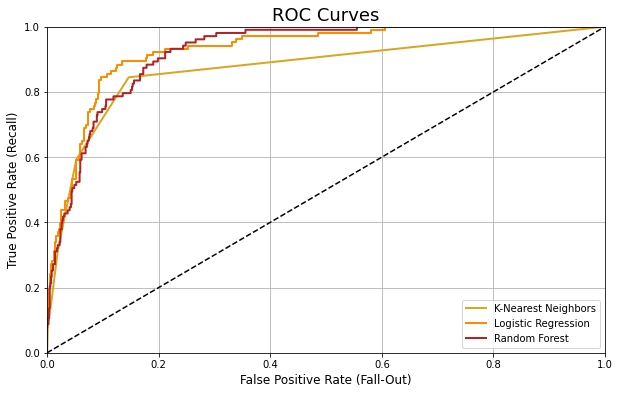

In [36]:
# ROC Curves
plt.figure(figsize=(10, 6))
plt.plot(fpr_knn, tpr_knn, linewidth=2, label='K-Nearest Neighbors', color='goldenrod')
plt.plot(fpr_lr, tpr_lr, linewidth=2, label='Logistic Regression', color='darkorange')
plt.plot(fpr_rf, tpr_rf, linewidth=2, label='Random Forest', color='firebrick')
plt.plot([0, 1], [0, 1], 'k--')
plt.axis([0, 1, 0, 1])
plt.title('ROC Curves', fontsize=18)
plt.xlabel('False Positive Rate (Fall-Out)', fontsize=12)
plt.ylabel('True Positive Rate (Recall)', fontsize=12)
plt.grid(True)   
plt.legend(loc='lower right')
plt.show()


## Model Comparison


### Summary Tables


In [37]:
models = [ rf_final, lr_final, knn_final ]

table_train = PrettyTable()
table_test = PrettyTable()
fields = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']
table_train.field_names = fields
table_test.field_names = fields

for model in models:
    model.fit(X_train, y_train)
    
    # Training metrics.
    y_pred_train = model.predict(X_train)
    accuracy_train = accuracy_score(y_train, y_pred_train)
    precision_train = precision_score(y_train, y_pred_train)
    recall_train = recall_score(y_train, y_pred_train)
    f1_train = f1_score(y_train, y_pred_train)
    roc_train = roc_auc_score(y_train, y_pred_train)
    table_train.add_row([type(model).__name__, format(accuracy_train, '.3f'), format(precision_train, '.3f'), format(recall_train,'.3f'), 
                         format(f1_train,'.3f'), format(roc_train,'.3f')])
    
    # Test metrics.
    y_pred_test = model.predict(X_test)
    accuracy_test = accuracy_score(y_test, y_pred_test)
    precision_test = precision_score(y_test, y_pred_test)
    recall_test = recall_score(y_test, y_pred_test)
    f1_test = f1_score(y_test, y_pred_test)
    roc_test = roc_auc_score(y_test, y_pred_test)
    table_test.add_row([type(model).__name__, format(accuracy_test, '.3f'), format(precision_test, '.3f'), format(recall_test,'.3f'), 
                         format(f1_test,'.3f'), format(roc_test,'.3f')])
    

print('FINAL SCORES FOR TRAINING DATA')
print(table_train)
print('\n\nFINAL SCORES FOR TEST DATA')
print(table_test)


FINAL SCORES FOR TRAINING DATA
+------------------------+----------+-----------+--------+----------+---------+
|         Model          | Accuracy | Precision | Recall | F1 Score | ROC AUC |
+------------------------+----------+-----------+--------+----------+---------+
| RandomForestClassifier |  0.857   |   0.427   | 0.913  |  0.582   |  0.881  |
|   LogisticRegression   |  0.885   |   0.484   | 0.874  |  0.623   |  0.880  |
|  KNeighborsClassifier  |  0.933   |   0.744   | 0.592  |  0.659   |  0.784  |
+------------------------+----------+-----------+--------+----------+---------+


FINAL SCORES FOR TEST DATA
+------------------------+----------+-----------+--------+----------+---------+
|         Model          | Accuracy | Precision | Recall | F1 Score | ROC AUC |
+------------------------+----------+-----------+--------+----------+---------+
| RandomForestClassifier |  0.854   |   0.374   | 0.944  |  0.535   |  0.895  |
|   LogisticRegression   |  0.877   |   0.410   | 0.889  |  

### Confusion Matrices

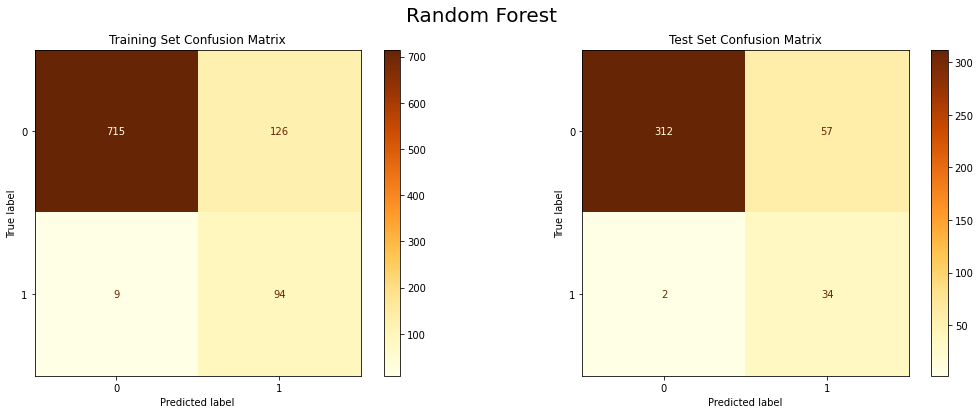

In [38]:
# Random Forest Confusion Matrices
fig, axes = plt.subplots(1, 2, figsize=(18,6))
ConfusionMatrixDisplay.from_estimator(rf_final, X_train, y_train, ax=axes[0], cmap='YlOrBr')
axes[0].set_title('Training Set Confusion Matrix')
ConfusionMatrixDisplay.from_estimator(rf_final, X_test, y_test, ax=axes[1], cmap='YlOrBr')
axes[1].set_title('Test Set Confusion Matrix')
plt.suptitle('Random Forest', fontsize=20)
plt.show()



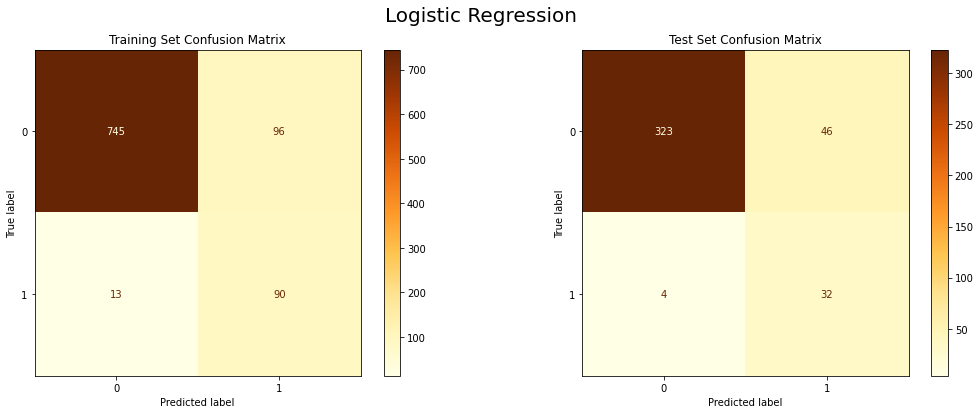

In [39]:
# Logistic Regression Confusion Matrices
fig, axes = plt.subplots(1, 2, figsize=(18,6))
ConfusionMatrixDisplay.from_estimator(lr_final, X_train, y_train, ax=axes[0], cmap='YlOrBr')
axes[0].set_title('Training Set Confusion Matrix')
ConfusionMatrixDisplay.from_estimator(lr_final, X_test, y_test, ax=axes[1], cmap='YlOrBr')
axes[1].set_title('Test Set Confusion Matrix')
plt.suptitle('Logistic Regression', fontsize=20)
plt.show()



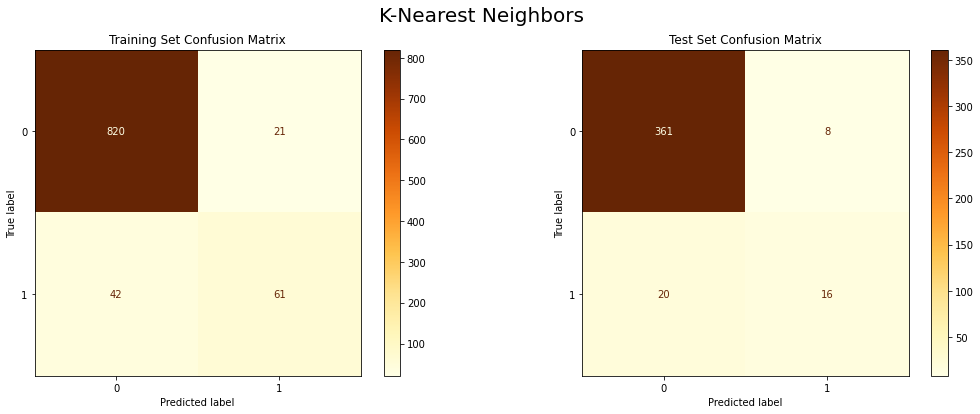

In [40]:
# K-Nearest Neighbors Confusion Matrices
fig, axes = plt.subplots(1, 2, figsize=(18,6))
ConfusionMatrixDisplay.from_estimator(knn_final, X_train, y_train, ax=axes[0], cmap='YlOrBr')
axes[0].set_title('Training Set Confusion Matrix')
ConfusionMatrixDisplay.from_estimator(knn_final, X_test, y_test, ax=axes[1], cmap='YlOrBr')
axes[1].set_title('Test Set Confusion Matrix')
plt.suptitle('K-Nearest Neighbors', fontsize=20)
plt.show()


### Feature Importance

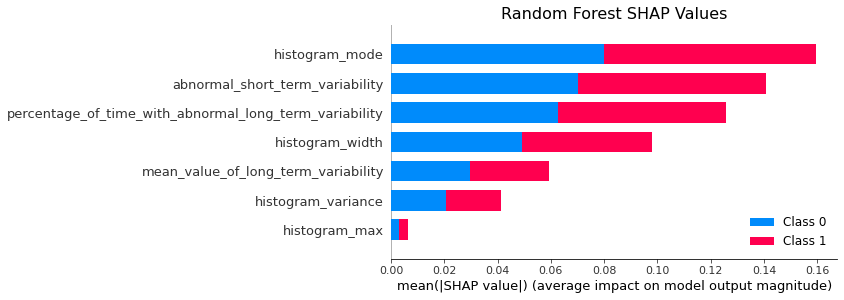

In [41]:
# Random Forest 
rf_explainer = shap.TreeExplainer(rf_final)
rf_shap_values = rf_explainer.shap_values(X_train, approximate=True)
fig = plt.figure(figsize=(15,10))
shap.summary_plot(rf_shap_values, features=X_train, feature_names=principal_components, plot_type='bar', show=False)
plt.title('Random Forest SHAP Values', fontsize=16)
plt.show()


In [42]:
# Logistic Regression
lr_coeff = pd.DataFrame(zip(principal_components, lr_final.coef_[0].transpose()), columns=['principal_component','coefficient'])
lr_coeff.sort_values(by=['coefficient'], ascending=False, inplace=True)
lr_coeff


,principal_component,coefficient
5,percentage_of_time_with_abnormal_long_term_var...,0.099880
2,abnormal_short_term_variability,0.091389
1,histogram_mode,0.059395
0,histogram_width,-0.017843
3,histogram_max,-0.032745
4,histogram_variance,-0.049697
6,mean_value_of_long_term_variability,-0.113501
